In [1]:
pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1073c0ef9eb93e16e486d63369695e4da7d99ab482a3b99c27906da108b9276a
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [2]:
# imports from the islp lab
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestClassifier as RF,
      GradientBoostingClassifier as GBR)


In [3]:
data = pd.read_csv("full_dataset.csv")


In [4]:
# setup for making a model
model = MS(data.columns.drop(['County','county_fips', 'prop_favored_dem_2020','winner_2020','county_names_with_casing','prop_favored_dem_2016',
       'prop_favored_dem_2012', 'prop_favored_dem_2008',
       'prop_favored_dem_2004', 'prop_favored_dem_2000', 'total_votes_2020', 'total_votes_2016',
       'total_votes_2012', 'total_votes_2008', 'total_votes_2004',
       'total_votes_2000', "State"]), intercept=False)
D = model.fit_transform(data)
feature_names = list(D.columns)
winner = data[["winner_2020"]].values.ravel()
X = np.asarray(D)




In [5]:
# train test split
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                                   winner,
                                   test_size=0.2,
                                   random_state=0)

In [6]:
# no max depth is given, as that is found through cross validation
# base tree before pruning
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.8869426751592356

test accuracy of 89% without pruning without election results

In [7]:
# making a tree with pruning
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and $\alpha$
 values from which we can extract an optimal one by cross-validation.

In [8]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.9130948207171314

While train accuracy didn't go down that much, it still seems incredibly high for a basic model.

Anyways, the basic model is:

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_export.py:670: UserWarning: Glyph 9 (	) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


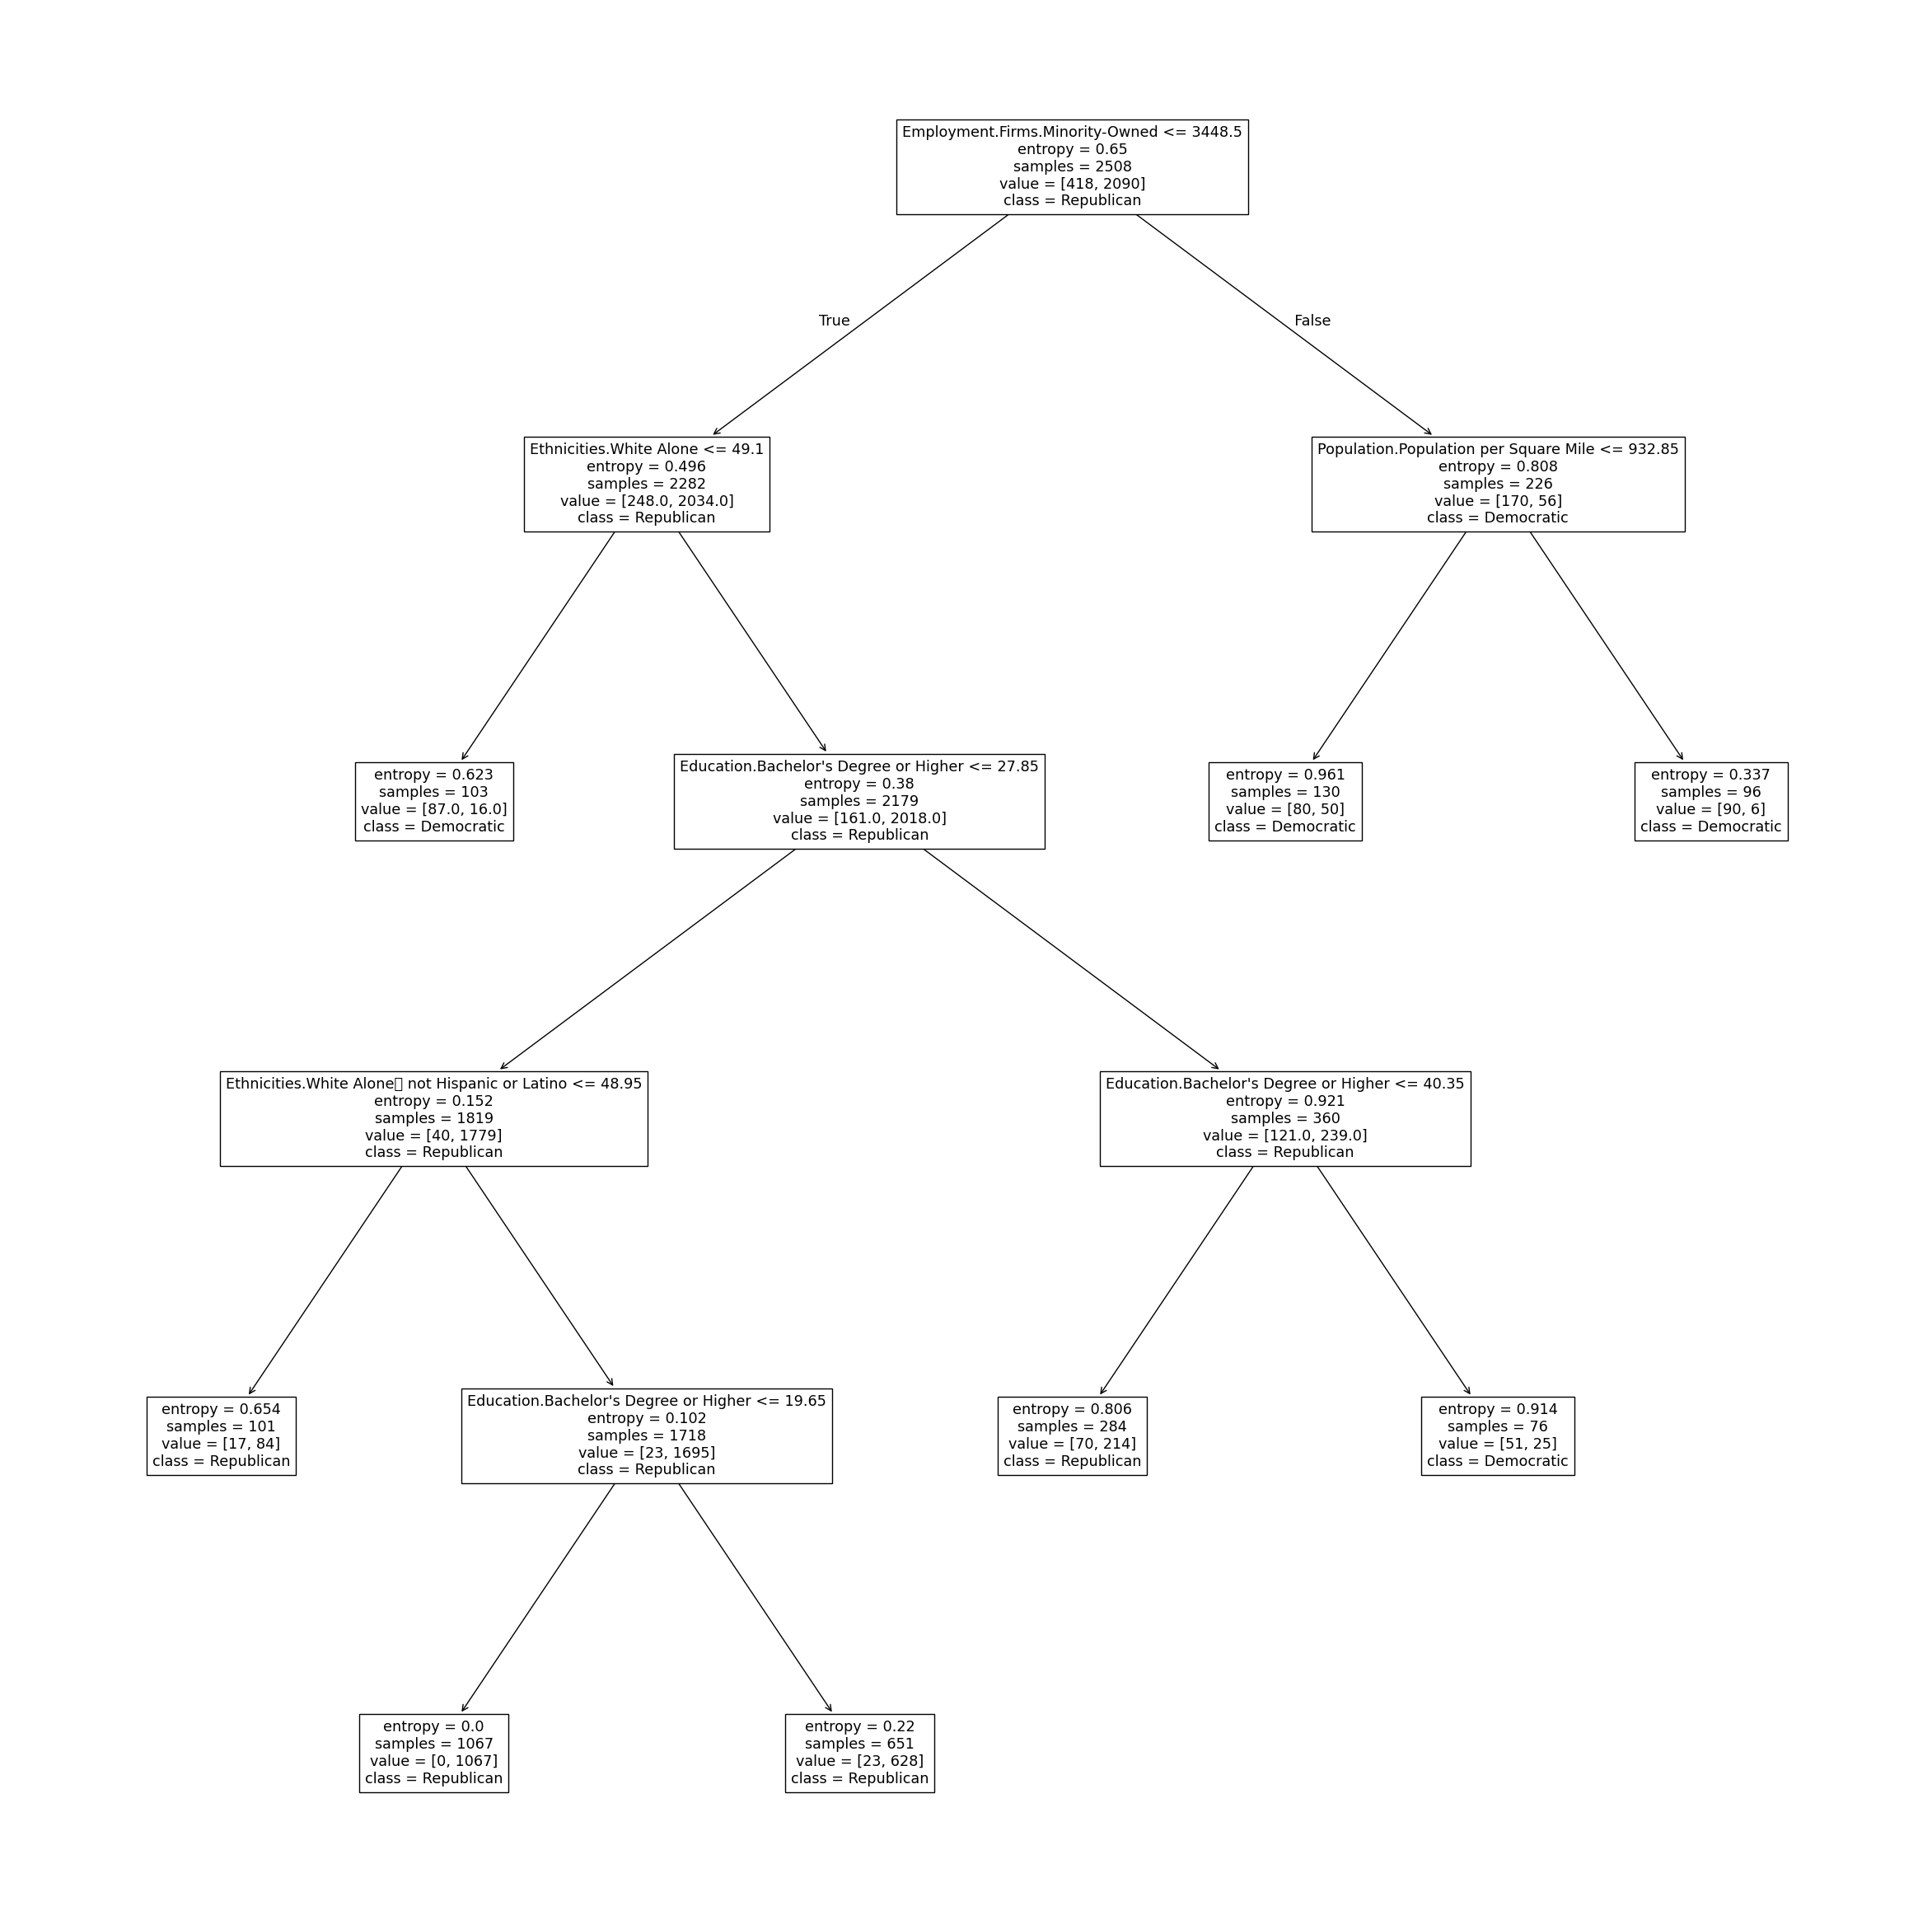

In [9]:
ax = subplots(figsize=(30, 30))[1] # the figsize needs to be increased to make them readable
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax, class_names = ["Democratic","Republican"]);


In [10]:
print(export_text(best_,
                  feature_names=feature_names,
                  show_weights=True))

|--- Employment.Firms.Minority-Owned <= 3448.50
|   |--- Ethnicities.White Alone <= 49.10
|   |   |--- weights: [87.00, 16.00] class: Democrat
|   |--- Ethnicities.White Alone >  49.10
|   |   |--- Education.Bachelor's Degree or Higher <= 27.85
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 48.95
|   |   |   |   |--- weights: [17.00, 84.00] class: Republican
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino >  48.95
|   |   |   |   |--- Education.Bachelor's Degree or Higher <= 19.65
|   |   |   |   |   |--- weights: [0.00, 1067.00] class: Republican
|   |   |   |   |--- Education.Bachelor's Degree or Higher >  19.65
|   |   |   |   |   |--- weights: [23.00, 628.00] class: Republican
|   |   |--- Education.Bachelor's Degree or Higher >  27.85
|   |   |   |--- Education.Bachelor's Degree or Higher <= 40.35
|   |   |   |   |--- weights: [70.00, 214.00] class: Republican
|   |   |   |--- Education.Bachelor's Degree or Higher >  40.35
|   |   |   |   |---

In [11]:
best_.tree_.n_leaves


8

In [12]:
# on test data
print(accuracy_score(y_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            y_test)
confusion

0.8964968152866242


Truth,Democrat,Republican
Predicted,,
Democrat,85,20
Republican,45,478


correct 65.4% of the time on democrat counties, 96.0% of the time on republican counties. Pruning seemed to improve the test error of the model. This version performs way worse than the version with states did on democrats specifically, but marginally better on republicans

Random Forests

In [23]:
forest = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = forest.predict(X_test)
# np.mean((y_test - y_hat_RF)**2)
np.sum(y_test == y_hat_RF) / len(y_test)

0.928343949044586

Oddly, adding a max features of 6 here has a higher test accuracy than with no max features

In [15]:
feature_imp = pd.DataFrame(
    {'importance':forest.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Ethnicities.White Alone,0.128388
Employment.Firms.Minority-Owned,0.101316
Education.Bachelor's Degree or Higher,0.094443
Ethnicities.White Alone\t not Hispanic or Latino,0.091151
Population.Population per Square Mile,0.071347
Employment.Firms.Women-Owned,0.052936
Population.2010 Population,0.034775
Employment.Firms.Total,0.032288
Housing.Persons per Household,0.031805
Income.Per Capita Income,0.029424


In [16]:
confusion_table(y_hat_RF, y_test)

Truth,Democrat,Republican
Predicted,,
Democrat,97,12
Republican,33,486


The random forest in this case performs better than the pruned tree, and has a higher test accuracy than the models that had states.

In [17]:
model_corr = MS(data.drop(['County', 'State', 'Population.2020 Population','Population.2010 Population', 'Employment.Firms.Total',
             'Employment.Firms.Women-Owned', 'Employment.Firms.Men-Owned', 'Employment.Firms.Minority-Owned',
             'Employment.Firms.Nonminority-Owned', 'Employment.Firms.Veteran-Owned', 'Employment.Firms.Nonveteran-Owned',
             'county_names_with_casing', 'county_fips', 'total_votes_2020', 'total_votes_2016', 'total_votes_2012', 'total_votes_2008',
             'total_votes_2004', 'total_votes_2000', 'prop_favored_dem_2020', 'prop_favored_dem_2016', 'prop_favored_dem_2012',
             'prop_favored_dem_2008', 'prop_favored_dem_2004', 'prop_favored_dem_2000', 'winner_2020'], axis=1), intercept=False)
D_corr = model_corr.fit_transform(data)
feature_names_corr = list(D_corr.columns)
X_corr = np.asarray(D_corr)

# since the same random state is used, we can use the same y train and y test as before
(X_train_corr,
 X_test_corr,
 _,
 _) = skm.train_test_split(X_corr,winner,test_size=0.2,random_state=0)

In [18]:
X_train_corr[0]

array([1.6300e+01, 1.6200e+01, 8.9500e+01, 1.9000e+00, 9.6300e+01,
       9.4600e+01, 1.1678e+04, 2.4900e+00, 5.0506e+04, 2.3383e+04,
       1.8000e+00, 4.7041e+02, 6.0000e+00, 8.5200e+01, 5.0100e+01,
       6.8100e+01])

In [19]:
forest_corr = RF(random_state=0).fit(X_train_corr, y_train)
y_hat_RF_corr = forest_corr.predict(X_test_corr)
np.sum(y_test == y_hat_RF_corr) / len(y_test)

0.9315286624203821

In [20]:
confusion_table(y_hat_RF_corr, y_test)

Truth,Democrat,Republican
Predicted,,
Democrat,96,9
Republican,34,489


In [21]:
feature_imp_corr = pd.DataFrame(
    {'importance':forest_corr.feature_importances_},
    index=feature_names_corr)
feature_imp_corr.sort_values(by='importance', ascending=False)

,importance
Ethnicities.White Alone,0.153393
Education.Bachelor's Degree or Higher,0.131812
Ethnicities.White Alone\t not Hispanic or Latino,0.116211
Population.Population per Square Mile,0.110382
Housing.Households,0.099446
Income.Per Capita Income,0.047924
Miscellaneous.Foreign Born,0.044389
Miscellaneous.Language Other than English at Home,0.039397
Housing.Persons per Household,0.037811
Income.Median Houseold Income,0.035817


Removing correlated predictors barely improved test accuracy.